<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit spectroscopy
# Step: flat_field() in Spec2Pipeline

<span style="color:red"> **Instruments Affected**</span>: MIRI 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* os for simple operating system functions
* gwcs.wcstools for bounding box operations
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot shapes
* crds for retrieving a reference file
* ci_watson from data retrieval from artifactory


[Top of Page](#title_ID)

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
from IPython.display import Markdown
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, collect_pipeline_cfgs
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.extract_2d import Extract2dStep
from jwst.flatfield import FlatFieldStep
from gwcs.wcstools import grid_from_bounding_box
import crds
from jwst import datamodels

from ci_watson.artifactory_helpers import get_bigdata

<a id="intro_ID"></a>
# Introduction


For this test we are using the flat fielding step for MIRI LRS slit data. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html#imaging-and-non-nirspec-spectroscopic-data

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/flat_field



### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

JWST: James Webb Space Telescope
MIRI: Mid-Infrared Instrument
LRS: Low Resolution Spectrometer


[Top of Page](#title_ID)

# Run Pipeline

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [4]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

### CalDetector1

We first run the data through the Detector1 pipeline. 

In [5]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True)
    if 'nod1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2022-12-03 08:41:42,114 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-12-03 08:41:42,136 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-03 08:41:42,137 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-03 08:41:42,138 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-03 08:41:42,139 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-03 08:41:42,140 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-03 08:41:42,141 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-03 08:41:42,142 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-03 08:41:42,143 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-03 08:41:42,144 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-03 08:41:42,145 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-03 08:41:42,146 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-03 08:41:42,147 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-03 08:41:42,148 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-03 08:41:42,149 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-03 08:41:42,150 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-03 08:41:42,151 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-03 08:41:42,153 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-03 08:41:42,343 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d/miri_lrs_slit_pt_nod1_v2.3.fits',).


2022-12-03 08:41:42,353 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-12-03 08:41:42,541 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-03 08:41:42,550 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-03 08:41:42,552 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-03 08:41:42,555 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-03 08:41:42,558 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-03 08:41:42,560 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-03 08:41:42,560 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2022-12-03 08:41:42,562 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-12-03 08:41:42,562 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-03 08:41:42,564 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-03 08:41:42,566 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-03 08:41:42,567 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-03 08:41:42,568 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-03 08:41:42,568 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-03 08:41:42,569 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-03 08:41:42,868 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:42,870 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:41:42,983 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-03 08:41:42,984 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-03 08:41:42,987 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-03 08:41:43,087 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:43,089 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:41:43,111 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-03 08:41:43,435 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-03 08:41:43,544 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:43,546 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'n_pix_grow_sat': 1}


2022-12-03 08:41:43,570 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-03 08:41:44,972 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-12-03 08:41:44,984 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-03 08:41:44,993 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-03 08:41:45,100 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:45,102 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:41:45,103 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-03 08:41:45,106 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-03 08:41:45,195 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:45,196 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:41:45,317 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-03 08:41:45,415 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:45,417 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:41:45,535 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-03 08:41:45,638 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:45,640 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:41:45,668 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-03 08:41:50,180 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-03 08:41:50,393 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:50,395 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:41:50,422 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-03 08:41:52,264 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-03 08:41:52,390 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:52,392 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'type': 'baseline'}


2022-12-03 08:41:52,417 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-03 08:41:52,587 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-03 08:41:52,689 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:41:52,691 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'dark_output': None}


2022-12-03 08:41:52,716 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-03 08:42:20,726 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-12-03 08:42:20,727 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-03 08:42:21,564 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-03 08:42:21,686 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:42:21,687 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-03 08:42:21,808 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-12-03 08:42:21,809 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-12-03 08:42:21,809 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-12-03 08:42:21,810 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-12-03 08:42:21,810 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-12-03 08:42:21,811 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-12-03 08:42:21,811 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-12-03 08:42:21,812 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-12-03 08:42:21,813 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-12-03 08:42:22,064 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-12-03 08:42:22,116 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-03 08:42:22,215 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:42:22,217 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-03 08:42:22,227 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-12-03 08:42:22,241 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-03 08:42:22,315 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-12-03 08:42:22,546 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-03 08:42:22,590 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-03 08:42:23,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28384 pixels with at least one CR from five or more groups.


2022-12-03 08:42:27,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-03 08:42:28,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12669 pixels with at least one CR from five or more groups.


2022-12-03 08:42:29,603 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.05544 sec


2022-12-03 08:42:29,672 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.444661


2022-12-03 08:42:29,678 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-03 08:42:29,810 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:42:29,811 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-03 08:42:29,847 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-12-03 08:42:29,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-03 08:42:29,900 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-03 08:42:29,901 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-03 08:42:29,994 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-03 08:42:29,995 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-03 08:42:41,242 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-12-03 08:42:41,244 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-12-03 08:42:41,339 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-03 08:42:41,474 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:42:41,475 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:41,516 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 08:42:41,517 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 08:42:41,522 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 08:42:41,624 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-12-03 08:42:41,625 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:41,668 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 08:42:41,668 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 08:42:41,673 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 08:42:41,763 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2022-12-03 08:42:41,764 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-03 08:42:41,764 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:42:41,830 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-12-03 08:42:41,830 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-12-03 08:42:42,020 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-12-03 08:42:42,039 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-12-03 08:42:42,040 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-12-03 08:42:42,042 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-12-03 08:42:42,043 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-12-03 08:42:42,044 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-12-03 08:42:42,045 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-12-03 08:42:42,046 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-12-03 08:42:42,048 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-12-03 08:42:42,049 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-12-03 08:42:42,050 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-12-03 08:42:42,051 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-12-03 08:42:42,052 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-12-03 08:42:42,053 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-12-03 08:42:42,055 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-12-03 08:42:42,056 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-12-03 08:42:42,058 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-12-03 08:42:42,059 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-12-03 08:42:42,161 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d/miri_lrs_slit_pt_nod2_v2.3.fits',).


2022-12-03 08:42:42,171 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-12-03 08:42:42,345 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-12-03 08:42:42,357 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-12-03 08:42:42,360 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-12-03 08:42:42,361 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-12-03 08:42:42,364 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-12-03 08:42:42,367 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-12-03 08:42:42,367 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2022-12-03 08:42:42,369 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-12-03 08:42:42,370 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-12-03 08:42:42,372 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-12-03 08:42:42,374 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-12-03 08:42:42,375 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-12-03 08:42:42,376 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-12-03 08:42:42,376 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-12-03 08:42:42,377 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-12-03 08:42:42,653 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:42,655 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:42,769 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-12-03 08:42:42,770 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-12-03 08:42:42,773 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-12-03 08:42:42,874 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:42,875 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:42,897 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-12-03 08:42:43,149 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-12-03 08:42:43,251 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:43,253 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'n_pix_grow_sat': 1}


2022-12-03 08:42:43,274 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-12-03 08:42:44,192 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-12-03 08:42:44,204 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-12-03 08:42:44,212 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-12-03 08:42:44,315 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:44,316 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:44,316 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-12-03 08:42:44,319 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-12-03 08:42:44,411 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:44,412 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:44,531 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-12-03 08:42:44,635 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:44,636 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:44,754 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-12-03 08:42:44,856 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:44,858 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:44,882 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-12-03 08:42:45,244 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-12-03 08:42:45,350 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:45,352 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:42:45,375 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-12-03 08:42:45,786 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-12-03 08:42:45,890 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:45,892 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'type': 'baseline'}


2022-12-03 08:42:45,915 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-12-03 08:42:46,070 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-12-03 08:42:46,176 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:46,178 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'dark_output': None}


2022-12-03 08:42:46,201 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-12-03 08:42:47,705 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-12-03 08:42:47,706 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-12-03 08:42:48,442 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-12-03 08:42:48,564 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:48,566 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-12-03 08:42:48,684 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-12-03 08:42:48,684 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-12-03 08:42:48,685 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-12-03 08:42:48,686 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-12-03 08:42:48,686 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-12-03 08:42:48,686 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-12-03 08:42:48,687 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-12-03 08:42:48,687 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-12-03 08:42:48,690 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-12-03 08:42:48,931 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-12-03 08:42:48,984 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-12-03 08:42:49,088 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:49,089 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0, 'min_sat_area': 1.0, 'min_jump_area': 5.0, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}


2022-12-03 08:42:49,099 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-12-03 08:42:49,113 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-03 08:42:49,151 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-12-03 08:42:49,346 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-12-03 08:42:49,388 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-12-03 08:42:50,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28153 pixels with at least one CR from five or more groups.


2022-12-03 08:42:53,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-12-03 08:42:54,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12958 pixels with at least one CR from five or more groups.


2022-12-03 08:42:56,291 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.94322 sec


2022-12-03 08:42:56,350 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.250097


2022-12-03 08:42:56,355 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-12-03 08:42:56,461 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:42:56,462 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-12-03 08:42:56,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-12-03 08:42:56,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-12-03 08:42:56,555 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-12-03 08:42:56,556 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-12-03 08:42:56,642 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-12-03 08:42:56,644 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-12-03 08:43:08,135 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-12-03 08:43:08,137 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-12-03 08:43:08,225 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-12-03 08:43:08,359 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:43:08,361 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:43:08,400 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 08:43:08,401 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 08:43:08,405 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 08:43:08,510 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-12-03 08:43:08,511 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp8geqsi6d'}


2022-12-03 08:43:08,553 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-12-03 08:43:08,554 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-12-03 08:43:08,558 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-12-03 08:43:08,648 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2022-12-03 08:43:08,649 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-12-03 08:43:08,649 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:43:08,714 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-12-03 08:43:08,715 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [6]:
print(det1_out)
print(nods)

[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>]
['nod1', 'nod2']


### CalSpec2

Next up are the CalSpec2 steps up to flat fielding. 

In [7]:
awcs_nod1 = AssignWcsStep.call(det1_out[0], save_results=True)
awcs_nod2 = AssignWcsStep.call(det1_out[1], save_results=True)

2022-12-03 08:43:08,739 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-03 08:43:08,846 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-12-03 08:43:08,847 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-03 08:43:09,141 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-03 08:43:09,231 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-12-03 08:43:09,232 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-12-03 08:43:09,233 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-12-03 08:43:09,246 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:43:09,416 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2022-12-03 08:43:09,417 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-12-03 08:43:09,426 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-12-03 08:43:09,535 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-12-03 08:43:09,536 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-12-03 08:43:09,786 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-12-03 08:43:09,872 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-12-03 08:43:09,873 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-12-03 08:43:09,873 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-12-03 08:43:09,886 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:43:10,057 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2022-12-03 08:43:10,058 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Let's check the location of the bounding box that has been attached to the data.
There is a dedicated notebook for this step, but top-level checks are:
* the bounding box coordinates should be the same for both nods
* the spectral trace should fall within the bounding box boundary

In [8]:
bbox_w_n1 = awcs_nod1.meta.wcs.bounding_box[0][1] - awcs_nod1.meta.wcs.bounding_box[0][0]
bbox_ht_n1 = awcs_nod1.meta.wcs.bounding_box[1][1] - awcs_nod1.meta.wcs.bounding_box[1][0]
print('Model bbox for nod 1 = {0} '.format(awcs_nod1.meta.wcs.bounding_box))
print('Model: Height x width of bounding box for nod 1 = {0} x {1} pixels'.format(bbox_ht_n1, bbox_w_n1))

bbox_w_n2 = awcs_nod2.meta.wcs.bounding_box[0][1] - awcs_nod2.meta.wcs.bounding_box[0][0]
bbox_ht_n2 = awcs_nod2.meta.wcs.bounding_box[1][1] - awcs_nod2.meta.wcs.bounding_box[1][0]
print('Model bbox for nod 2 = {0} '.format(awcs_nod1.meta.wcs.bounding_box))
print('Model: Height x width of bounding box for nod 2 = {0} x {1} pixels'.format(bbox_ht_n2, bbox_w_n2))

Model bbox for nod 1 = ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=6.5, upper=396.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
) 
Model: Height x width of bounding box for nod 1 = 390.0 x 44.0 pixels
Model bbox for nod 2 = ModelBoundingBox(
    intervals={
        x0: Interval(lower=302.5, upper=346.5)
        x1: Interval(lower=6.5, upper=396.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='C'
) 
Model: Height x width of bounding box for nod 2 = 390.0 x 44.0 pixels


miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


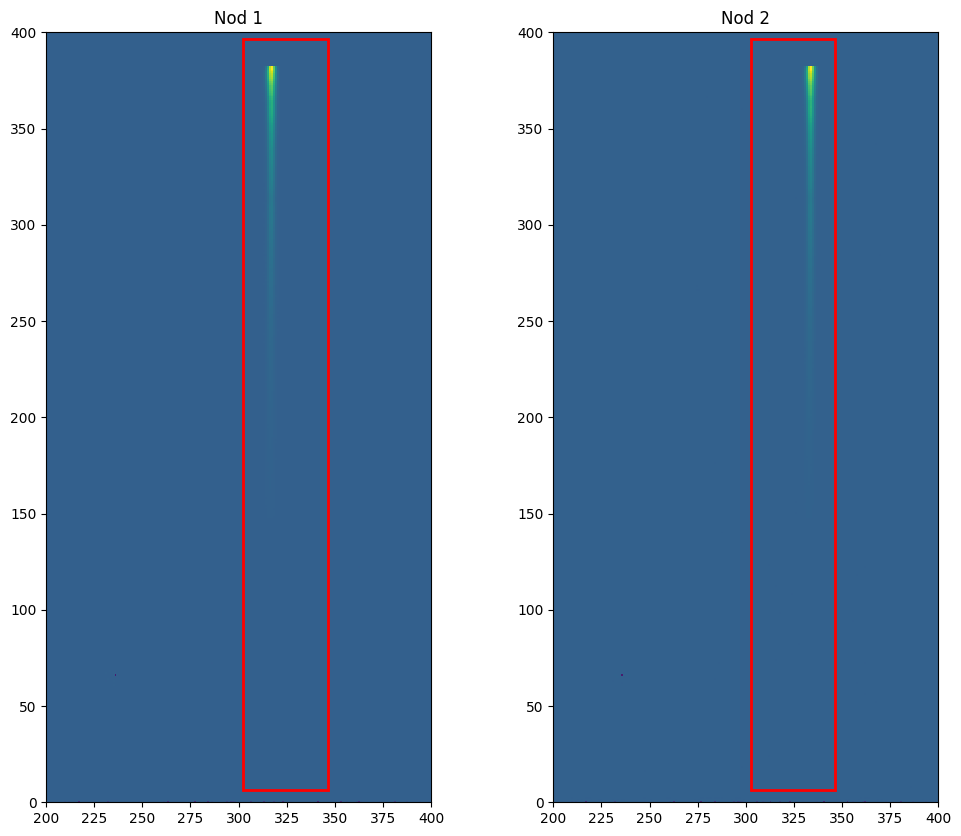

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,10])
bbox1 = Rectangle((awcs_nod1.meta.wcs.bounding_box[0][0],awcs_nod1.meta.wcs.bounding_box[1][0]), bbox_w_n1, bbox_ht_n1, angle=0.0, ec='r', lw=2, fc='None')
ax[0].imshow(awcs_nod1.data, origin='lower', aspect='equal', interpolation='None')
ax[0].set_title('Nod 1')
ax[0].add_patch(bbox1)
ax[0].set_xlim([200,400])
ax[0].set_ylim([0,400])

bbox2 = Rectangle((awcs_nod2.meta.wcs.bounding_box[0][0],awcs_nod2.meta.wcs.bounding_box[1][0]), bbox_w_n2, bbox_ht_n2, angle=0.0, ec='r', lw=2, fc='None')
ax[1].imshow(awcs_nod2.data, origin='lower', aspect='equal', interpolation='None')
ax[1].set_title('Nod 2')
ax[1].add_patch(bbox2)
ax[1].set_xlim([200,400])
ax[1].set_ylim([0,400])

print(awcs_nod1.meta.filename)

In [10]:
bgsub_1 = [awcs_nod2.meta.filename]
bgsub_2 = [awcs_nod1.meta.filename]

In [11]:
bgr_nod1 = BackgroundStep.call(awcs_nod1, bgsub_1, save_results='True')
bgr_nod2 = BackgroundStep.call(awcs_nod2, bgsub_2, save_results='True')

2022-12-03 08:43:10,470 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2022-12-03 08:43:10,581 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>, ['miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits']).


2022-12-03 08:43:10,582 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-12-03 08:43:10,728 - stpipe.BackgroundStep - INFO - Accumulate bkg from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2022-12-03 08:43:11,295 - stpipe.BackgroundStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_backgroundstep.fits


2022-12-03 08:43:11,296 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


2022-12-03 08:43:11,305 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2022-12-03 08:43:11,426 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>, ['miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits']).


2022-12-03 08:43:11,427 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-12-03 08:43:11,573 - stpipe.BackgroundStep - INFO - Accumulate bkg from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2022-12-03 08:43:12,111 - stpipe.BackgroundStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_backgroundstep.fits


2022-12-03 08:43:12,112 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


Check the output of the background subtraction. We should now have in each exposure a positive and negative spectral trace, with the sides of pos-neg switched between them.

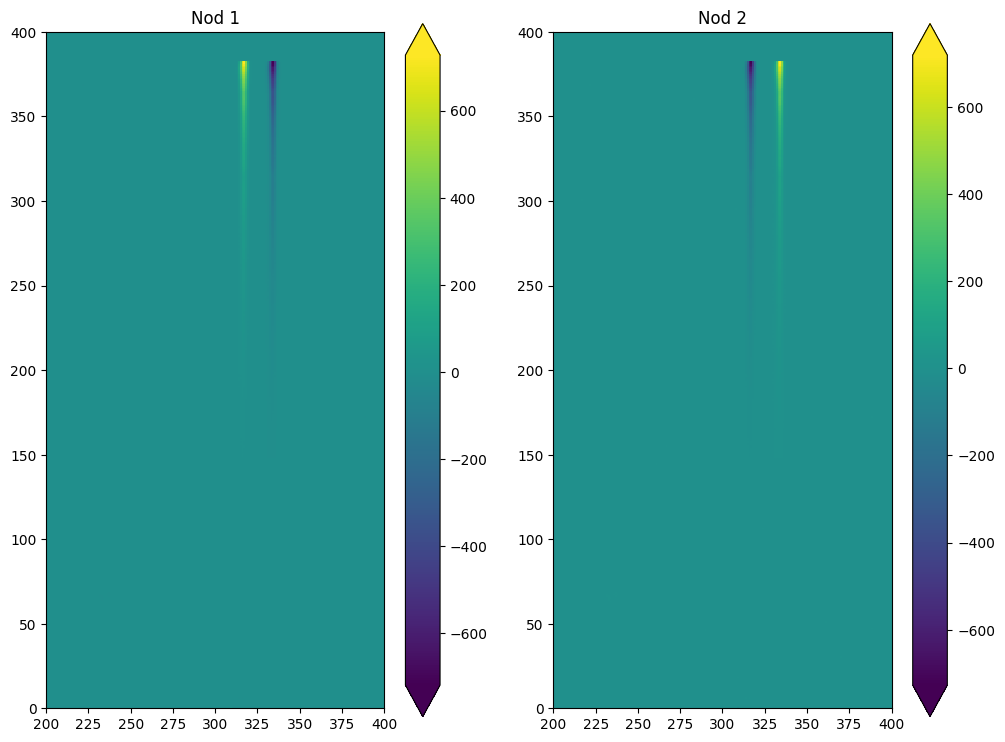

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=[12,10])
im1 = ax[0].imshow(bgr_nod1.data, origin='lower', aspect='equal', interpolation='None')
ax[0].set_title('Nod 1')
ax[0].set_xlim([200,400])
ax[0].set_ylim([0,400])
cbar1= fig.colorbar(im1, extend='both', shrink=0.9, ax=ax[0])

im2 = ax[1].imshow(bgr_nod2.data, origin='lower', aspect='equal', interpolation='None')
ax[1].set_title('Nod 2')
ax[1].set_xlim([200,400])
ax[1].set_ylim([0,400])
cbar2= fig.colorbar(im2, extend='both', shrink=0.9, ax=ax[1])

In [13]:
e2d_nod1 = Extract2dStep.call(bgr_nod1, save_results='True')
e2d_nod2 = Extract2dStep.call(bgr_nod2, save_results='True')

2022-12-03 08:43:12,572 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


2022-12-03 08:43:12,703 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_backgroundstep.fits>,).


2022-12-03 08:43:12,704 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}


2022-12-03 08:43:12,719 - stpipe.Extract2dStep - INFO - EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-12-03 08:43:12,719 - stpipe.Extract2dStep - INFO - EXP_TYPE MIR_LRS-FIXEDSLIT not supported for extract 2D


2022-12-03 08:43:12,724 - stpipe.Extract2dStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:43:12,919 - stpipe.Extract2dStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_extract2dstep.fits


2022-12-03 08:43:12,920 - stpipe.Extract2dStep - INFO - Step Extract2dStep done


2022-12-03 08:43:12,930 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.


2022-12-03 08:43:13,058 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_backgroundstep.fits>,).


2022-12-03 08:43:13,059 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}


2022-12-03 08:43:13,073 - stpipe.Extract2dStep - INFO - EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-12-03 08:43:13,074 - stpipe.Extract2dStep - INFO - EXP_TYPE MIR_LRS-FIXEDSLIT not supported for extract 2D


2022-12-03 08:43:13,078 - stpipe.Extract2dStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:43:13,253 - stpipe.Extract2dStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_extract2dstep.fits


2022-12-03 08:43:13,254 - stpipe.Extract2dStep - INFO - Step Extract2dStep done


In [14]:
ff_nod1 = FlatFieldStep.call(e2d_nod1, save_results='True')
ff_nod2 = FlatFieldStep.call(e2d_nod2, save_results='True')

2022-12-03 08:43:13,268 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2022-12-03 08:43:13,392 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_extract2dstep.fits>,).


2022-12-03 08:43:13,393 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-03 08:43:13,587 - stpipe.FlatFieldStep - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED', 'NRC_WFS

2022-12-03 08:43:13,841 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:13,842 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:13,842 - stpipe.FlatFieldStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:13,862 - stpipe.FlatFieldStep - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:14,042 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:43:14,227 - stpipe.FlatFieldStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_flatfieldstep.fits


2022-12-03 08:43:14,228 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


2022-12-03 08:43:14,238 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2022-12-03 08:43:14,369 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_extract2dstep.fits>,).


2022-12-03 08:43:14,370 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-12-03 08:43:14,434 - stpipe.FlatFieldStep - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED', 'NRC_WFS

2022-12-03 08:43:14,483 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:14,484 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:14,484 - stpipe.FlatFieldStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:14,503 - stpipe.FlatFieldStep - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:14,678 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1019.pmap


2022-12-03 08:43:14,861 - stpipe.FlatFieldStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_flatfieldstep.fits


2022-12-03 08:43:14,862 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


# Flat Field Step Check

OK, so we now have the output from the flat fielding step. We will download the reference file from crds and perform an independent check that the step is correctly executed. 

In [15]:
#flat1_file = fits.open('flatfield_testing/det_image_seq1_MIRIMAGE_P750Lexp1_flat_field.fits')
#flat2_file = fits.open('flatfield_testing/det_image_seq2_MIRIMAGE_P750Lexp1_flat_field.fits')
#flat1 = flat1_file[1]
#flat2 = flat2_file[1]

Display flat, region chosen because all areas around the slit are nan's

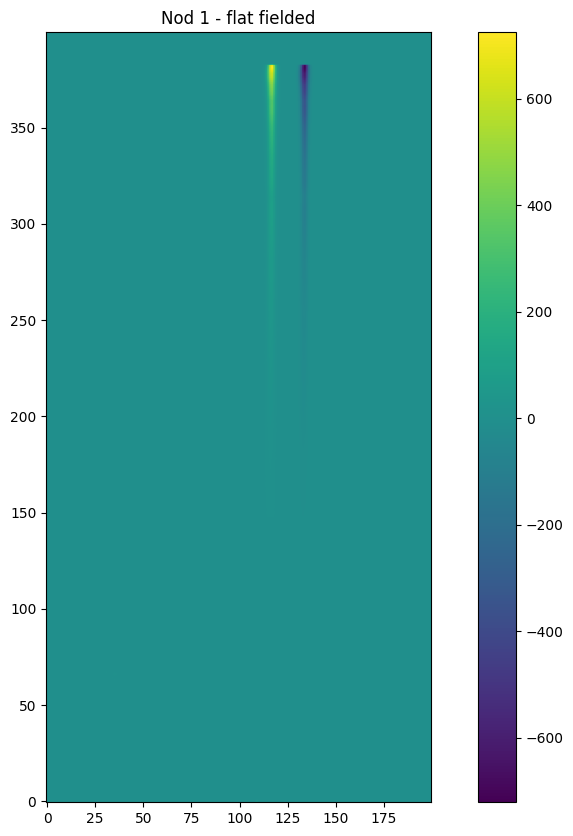

In [16]:
fig = plt.figure(figsize=[12,10])
plt.imshow(ff_nod1.data[:400, 200:400], origin='lower')
plt.title('Nod 1 - flat fielded')
plt.colorbar()

Let's now do a manual check based on the flat field reference file. We can access the name of this file from the model metadata (or the file header). The flat reference file has non-NaN value only in the region where the spectrum is dispersed. We'd like to check that this region covers at least that covered by the bounding box definition to ensure that that entire region will be accurately flat fielded. 

2022-12-03 08:43:15,163 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED', 'NRC_WFSC', 'NRC_TACON

2022-12-03 08:43:15,211 - stpipe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:15,212 - stpipe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:15,213 - stpipe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-12-03 08:43:15,232 - stpipe - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


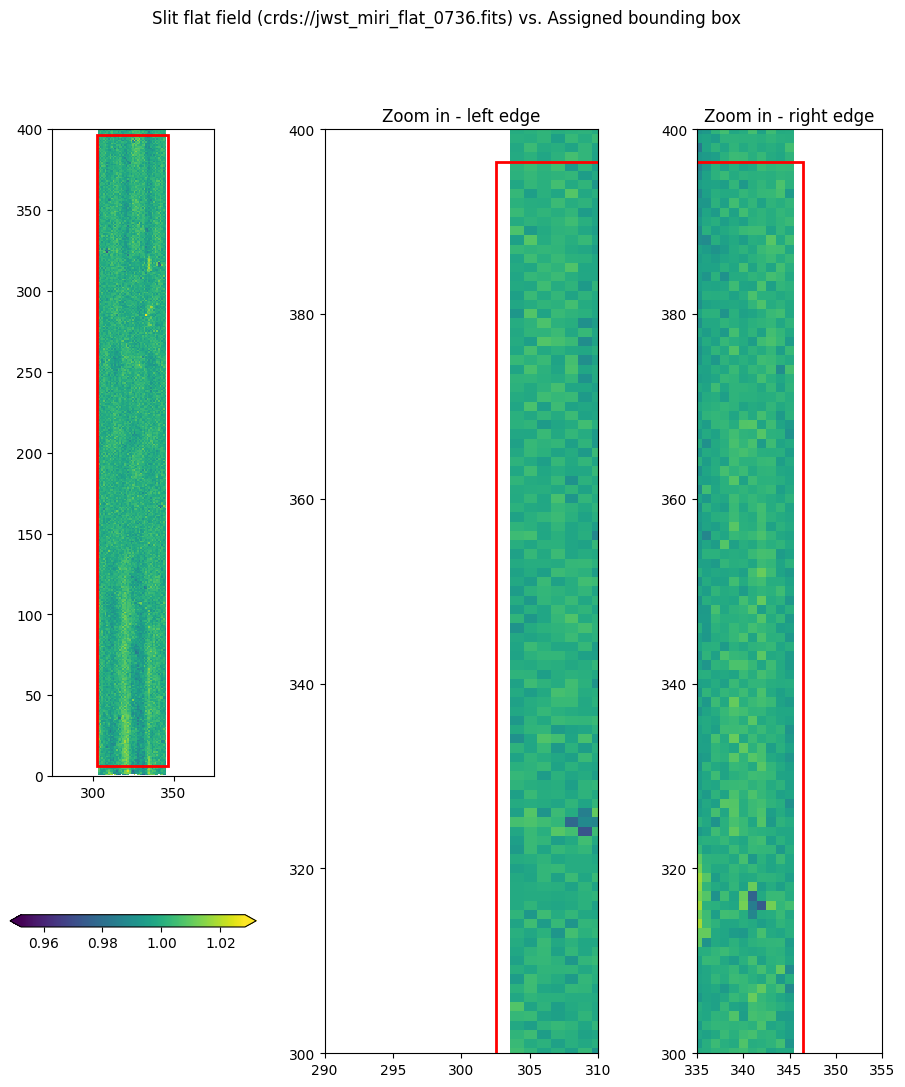

In [17]:
flat_reffile = ff_nod1.meta.ref_file.flat.name
basename = crds.core.config.pop_crds_uri(flat_reffile)
filepath = crds.locate_file(basename, "jwst")
reffile =  datamodels.open(filepath)
#print(reffile.data[0:430,304:346])
bbox2 = Rectangle((awcs_nod1.meta.wcs.bounding_box[0][0],awcs_nod1.meta.wcs.bounding_box[1][0]), bbox_w_n1, bbox_ht_n1, angle=0.0, ec='r', lw=2, fc='None')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12, 12])
im0 = ax[0].imshow(reffile.data, origin='lower', interpolation='None')
ax[0].add_patch(bbox2)
ax[0].set_xlim([275,375])
ax[0].set_ylim([0,400])
cbar = fig.colorbar(im0,  extend='both', orientation='horizontal', shrink=0.9, ax=ax[0])

bbox3 = Rectangle((awcs_nod1.meta.wcs.bounding_box[0][0],awcs_nod1.meta.wcs.bounding_box[1][0]), bbox_w_n1, bbox_ht_n1, angle=0.0, ec='r', lw=2, fc='None')
ax[1].imshow(reffile.data, origin='lower', interpolation='None', aspect='auto')
ax[1].add_patch(bbox3)
ax[1].set_xlim([290,310])
ax[1].set_ylim([300,400])
ax[1].set_title('Zoom in - left edge')

bbox4 = Rectangle((awcs_nod1.meta.wcs.bounding_box[0][0],awcs_nod1.meta.wcs.bounding_box[1][0]), bbox_w_n1, bbox_ht_n1, angle=0.0, ec='r', lw=2, fc='None')
ax[2].imshow(reffile.data, origin='lower', interpolation='None')
ax[2].add_patch(bbox4)
ax[2].set_xlim([335,355])
ax[2].set_ylim([300,400])
ax[2].set_title('Zoom in - right edge')

#fig.tight_layout()

plt.suptitle('Slit flat field ({}) vs. Assigned bounding box'.format(flat_reffile))
plt.savefig('slit_flatfield_boundingbox.png')

In [18]:
def flatfield_corners(arr):
    # create a boolean array for the NaNs
    barr = np.isnan(arr)
    
    # then extarct the indices where boolean array is False
    ii = np.where(~barr)
    
    # then identify the corner coordinates
    xmin, xmax = np.min(ii[1]), np.max(ii[1])
    ymin, ymax = np.min(ii[0]), np.max(ii[0])
    
    return xmin, xmax, ymin, ymax

Compare the corner coordinates of the flat field region with the corners of the bounding box. We check to ensure that the flat field region is NOT SMALLER than the bounding box region. Bigger is not a problem.

In [19]:
# get the corner coordinates of the flat field region using the above function
ff_xmin, ff_xmax, ff_ymin, ff_ymax = flatfield_corners(reffile.data)
print(ff_xmin, ff_xmax, ff_ymin, ff_ymax)

# get the boundign box coordinates
bb_xmin, bb_xmax, bb_ymin, bb_ymax = awcs_nod1.meta.wcs.bounding_box[0][0], awcs_nod1.meta.wcs.bounding_box[0][1], awcs_nod1.meta.wcs.bounding_box[1][0], awcs_nod1.meta.wcs.bounding_box[1][1]
print(bb_xmin, bb_xmax, bb_ymin, bb_ymax)

try:
    assert(ff_xmin <= bb_xmin) and (ff_xmax >= bb_xmax), "Flat field region SMALLER than BBox in X"
except AssertionError as e:
    print("************************************************")
    print("")
    print("ERROR: {}".format(e))
    print("")
    print("************************************************")

try:
    assert(ff_ymin <= bb_ymin) and (ff_ymax >= bb_ymax), "Flat field region SMALLER than BBox in Y"
except AssertionError as e:
    print("************************************************")
    print("")
    print("ERROR: {}".format(e))
    print("")
    print("************************************************")

304 345 1 429
302.5 346.5 6.5 396.5
************************************************

ERROR: Flat field region SMALLER than BBox in X

************************************************



Now we go back to the output of the step prior to flat fielding (extract_2d()), and perform the flat fielding manually. This should be a straightfoward division. The variables are ``e2d_nod1`` and ``e2d_nod2``.

In [20]:
manflat_nod1 = e2d_nod1.data / reffile.data
manflat_nod2 = e2d_nod2.data / reffile.data

Compare the output to the pipeline flat field output (``ff_nod1`` and ``ff_nod2``). We use the ``np.allclose()`` function to compare two arrays element-wise. We accept the default tolerances ``atol = 1e-08`` and ``rtol = `e-05``, which means that:

``abs(ff_nod1.data - manflat_nod1) <= 1e-08 + 1e-05 * manflat_nod1``

2022-12-03 08:43:15,955 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_3597876/4076650748.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im0 = ax[0].imshow(fcheck_nod1[np.int(bb_ymin):np.int(bb_ymax), np.int(bb_xmin):np.int(bb_xmax)], origin='lower', interpolation='None')



2022-12-03 08:43:15,973 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_3597876/4076650748.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = ax[1].imshow(fcheck_nod2[np.int(bb_ymin):np.int(bb_ymax), np.int(bb_xmin):np.int(bb_xmax)], origin='lower', interpolation='None')



Min difference between manual & pipeline files, nod 1 = 0.0 -- Max = 0.0
Min difference between manual & pipeline files, nod 2 = 0.0 -- Max = 0.0


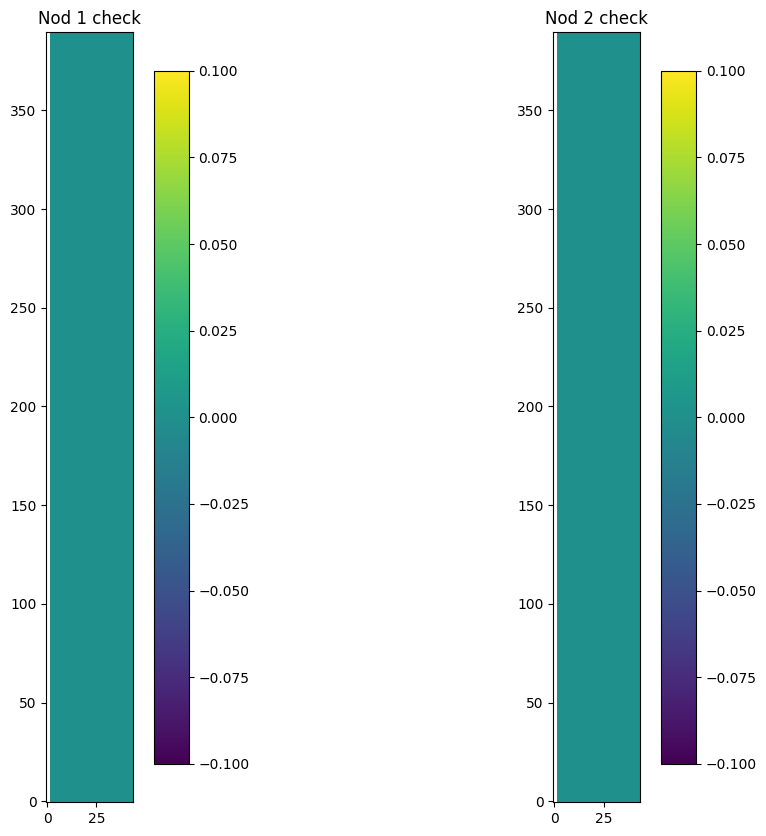

In [21]:
fcheck_nod1 = (ff_nod1.data - manflat_nod1)
fcheck_nod2 = (ff_nod2.data - manflat_nod2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,10])
im0 = ax[0].imshow(fcheck_nod1[np.int(bb_ymin):np.int(bb_ymax), np.int(bb_xmin):np.int(bb_xmax)], origin='lower', interpolation='None')
ax[0].set_title('Nod 1 check')
cbar = fig.colorbar(im0, shrink=0.9, ax=ax[0])


im1 = ax[1].imshow(fcheck_nod2[np.int(bb_ymin):np.int(bb_ymax), np.int(bb_xmin):np.int(bb_xmax)], origin='lower', interpolation='None')
ax[1].set_title('Nod 2 check')
cbar2 = fig.colorbar(im1, shrink=0.9, ax=ax[1])

nans1 = np.isnan(fcheck_nod1)
nans2 = np.isnan(fcheck_nod2)
print('Min difference between manual & pipeline files, nod 1 = {0} -- Max = {1}'.format(np.min(fcheck_nod1[~nans1]), np.max(fcheck_nod1[~nans1])))
print('Min difference between manual & pipeline files, nod 2 = {0} -- Max = {1}'.format(np.min(fcheck_nod2[~nans2]), np.max(fcheck_nod2[~nans2])))

# perform a numeric check. Ignoring NaNs for now as these do not fully match:
try:
    assert (np.allclose(ff_nod1.data[~nans1], manflat_nod1[~nans1], equal_nan=True) and np.allclose(ff_nod2.data[~nans2], manflat_nod2[~nans2], equal_nan=True))
except:    
    print("AssertionError: Pipeline calibrated file doesn't match the manual check to within tolerances") 

If all assert statements in this notebook PASS, then the test is successful.

**END**

Authors: K. Murray (kmurray@stsci.edu), S. Kendrew (sarah.kendrew@esa.int) -- MIRI branch
